In [477]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .appName("ECG") \
    .getOrCreate()

sc = spark.sparkContext

In [478]:
import math

oversampling = True
train_part_num = 10
test_part_num = 10
k = 7
in_k = max(math.floor(k/train_part_num), 1)

In [479]:
if not oversampling:
    # df = spark.read.csv("abfss://team6@sauondbrwebigdatalrs1.dfs.core.windows.net/ECG5000/ECG5000_TRAIN.tsv",sep=r'\t', header=True)
    train_df = spark.read.csv("../data/ECG5000/ECG5000_TRAIN.tsv", sep='\t', header=False)
    test_df = spark.read.csv("../data/ECG5000/ECG5000_TEST.tsv" ,sep='\t', header=False)

In [480]:
from pyspark.sql.functions import rand

if not oversampling:
    train_df = train_df.orderBy(rand()) #.limit(100)
    test_df = test_df.orderBy(rand()) #.limit(15)

In [481]:
from pyspark.sql.functions import col

if not oversampling:
    train_df = train_df.withColumnRenamed("_c0", "Class")
    test_df = test_df.withColumnRenamed("_c0", "Class")

    for col_name in train_df.columns[1:]:
        if col_name != "Class":
            train_df = train_df.withColumn(col_name, col(col_name).cast("float"))

    for col_name in test_df.columns[1:]:
        if col_name != "Class":
            test_df = test_df.withColumn(col_name, col(col_name).cast("float"))

    # Append the rows from test_df to train_df
    merged_df = train_df.union(test_df) 

In [482]:
if oversampling:
    merged_df = spark.read.csv("../data/ECG5000/ECG5000_Oversampled.csv", header=True)
    merged_df = merged_df.orderBy(rand(seed=42))

# Show the resulting dataframe
merged_df.count()

6300

In [483]:
merged_df = merged_df.limit(1000)

In [484]:
merged_df.show(5)

+-----+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+----------------

In [485]:
# Define the split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data into train and test sets
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=346)

In [486]:
train_df.groupBy("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    1| 2069|
|    2| 1241|
|    3|  414|
|    5|  285|
|    4|  429|
+-----+-----+



In [487]:
train_df.count()

4438

In [488]:
train_df.cache()
test_df.cache()

23/05/11 20:09:51 WARN CacheManager: Asked to cache already cached data.
23/05/11 20:09:51 WARN CacheManager: Asked to cache already cached data.


DataFrame[Class: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71

In [489]:
# for df in [train_df, test_df]:
#     duplicates_df = df.dropDuplicates()
#     num_duplicates = df.count() - duplicates_df.count()
#     if num_duplicates > 0:
#         print("There are duplicate rows in the DataFrame.")
#     else:
#         print("There are no duplicate rows in the DataFrame.")

In [490]:
import pyspark.sql.functions as F
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

In [491]:
from pyspark.sql.functions import array, col, lit

# Determine the number of columns in each partition
num_cols = len(train_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // train_part_num
cols_remainder = num_cols % train_part_num

print("TOTAL COLS NUM:", num_cols)
print("COLUMNS PER PARTITION:", cols_per_part)
print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(train_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = train_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [22,0,4,1,2,23,5,7,13,6]
    df = train_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
train_df_part = result.repartition(train_part_num, "partition_id")

TOTAL COLS NUM: 140
COLUMNS PER PARTITION: 14
REMAINDER: 0
PARTITION 0 HAS 14 COLUMNS
PARTITION 1 HAS 14 COLUMNS
PARTITION 2 HAS 14 COLUMNS
PARTITION 3 HAS 14 COLUMNS
PARTITION 4 HAS 14 COLUMNS
PARTITION 5 HAS 14 COLUMNS
PARTITION 6 HAS 14 COLUMNS
PARTITION 7 HAS 14 COLUMNS
PARTITION 8 HAS 14 COLUMNS
PARTITION 9 HAS 14 COLUMNS


+------------+-----+
|partition_id|count|
+------------+-----+
|          22| 4438|
|           0| 4438|
|           4| 4438|
|           1| 4438|
|           2| 4438|
|          23| 4438|
|           5| 4438|
|           7| 4438|
|          13| 4438|
|           6| 4438|
+------------+-----+



In [492]:
train_rdd = train_df_part.rdd

# Check the number of partitions
num_partitions = train_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = train_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 10
Shape of each partition: [4438, 4438, 4438, 4438, 4438, 4438, 4438, 4438, 4438, 4438]


In [493]:
column_names = train_df_part.columns
def toPandas_partition(instances):
    panda_df = pd.DataFrame(columns = column_names)      # using the global variable
    
    for instance in instances:  # each instance is of Row type
        panda_df = pd.concat([panda_df, pd.DataFrame([instance.asDict()])], ignore_index=True)
  
    return [panda_df]

rdd_pandas = train_rdd.mapPartitions(toPandas_partition)

In [494]:
import random
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

def build_model(partition):

    knn = KNeighborsClassifier(n_neighbors=in_k, metric='euclidean')
    
    X_train = partition.drop('Class', axis=1)
    y_train = partition['Class']
    
    model = knn.fit(X_train, y_train)

    return (model, partition['partition_id'][0])

model_list = rdd_pandas.map(build_model).collect()

In [495]:
# Determine the number of columns in each partition
num_cols = len(test_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // test_part_num
cols_remainder = num_cols % test_part_num

# print("TOTAL COLS NUM:", num_cols)
# print("COLUMNS PER PARTITION:", cols_per_part)
# print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(test_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    # print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = test_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [22,0,4,1,2,23,5,7,13,6]
    df = test_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
test_df_part = result.repartition(test_part_num, "partition_id")

+------------+-----+
|partition_id|count|
+------------+-----+
|          22| 1862|
|           0| 1862|
|           4| 1862|
|           1| 1862|
|           2| 1862|
|          23| 1862|
|           5| 1862|
|           7| 1862|
|          13| 1862|
|           6| 1862|
+------------+-----+



In [496]:
test_rdd = test_df_part.rdd

# Check the number of partitions
num_partitions = test_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = test_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 10
Shape of each partition: [1862, 1862, 1862, 1862, 1862, 1862, 1862, 1862, 1862, 1862]


In [497]:
test_rdd_pandas = test_rdd.mapPartitions(toPandas_partition)

In [498]:
# Convert RDD to Pandas DataFrame
test_df_pandas = pd.concat(test_rdd_pandas.collect())

# # Print the dimensions and shape/size of the Pandas DataFrame
# print("Dimensions:", test_df_pandas.ndim)
# print("Shape/Size:", test_df_pandas.shape)

# # Show the column names in the Pandas DataFrame
# print("Column names:", test_df_pandas.columns)

In [499]:
def test_classifier(partition):
    predictions = []
    distances = []
    X_test = partition.drop('Class', axis=1)
    
    for m in model_list:
        if m[1] == partition['partition_id'][0]:
            _, neighbors = m[0].kneighbors(X_test)
            pred = m[0].predict(X_test).tolist()
            distances.append(neighbors.tolist())
            predictions.append(pred)

    return list(zip(predictions[0], distances[0]))

partition_predictions = test_rdd_pandas.map(test_classifier)

zipped = list(zip(*partition_predictions.collect()))
cur_k = int(k/len(zipped[0][0][1]))
rdd = sc.parallelize(zipped)
rdd1 = rdd.map(lambda x: sorted(x, key=lambda x: x[1][0], reverse=False)[:cur_k])

from collections import Counter

rdd2 = rdd1.map(lambda x: Counter([t[0] for t in x]).most_common(1)[0][0])


In [500]:
y_pred = rdd2.collect()

In [501]:
len(y_pred)

1862

In [502]:
y_pred

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1'

In [503]:
y_test = test_df.select("Class").collect()

In [504]:
from pyspark.sql.functions import when, count

y_pred_df = spark.createDataFrame([(i,) for i in y_pred], ['prediction'])
y_test_df = spark.createDataFrame(y_test, ['Class'])

In [505]:
from pyspark.sql.functions import monotonically_increasing_id

y_pred_df = y_pred_df.withColumn("id", monotonically_increasing_id())
y_test_df = y_test_df.withColumn("id", monotonically_increasing_id())

joined_df = y_pred_df.join(y_test_df, "id", "outer").drop("id")

joined_df = joined_df.withColumn('same_values', when(joined_df.prediction == joined_df.Class, 1).otherwise(0))

print("joined_df:")
joined_df.show(5)

joined_df:
+----------+-----+-----------+
|prediction|Class|same_values|
+----------+-----+-----------+
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
+----------+-----+-----------+
only showing top 5 rows



In [506]:
joined_df.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         3|  188|
|         5|  106|
|         1|  871|
|         4|   81|
|         2|  616|
+----------+-----+



In [507]:
percentage_same_values = joined_df.agg({'same_values': 'mean'}).collect()[0][0] * 100

print(f"{percentage_same_values:.2f}% of rows have the same label and prediction.")

91.89% of rows have the same label and prediction.


In [508]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

indexed_df = joined_df.withColumn("ClassIndex", col("Class").cast("integer"))

# Cast the prediction column to DoubleType
indexed_df = indexed_df.withColumn("prediction", col("prediction").cast("double"))

# Compute F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="ClassIndex", metricName="f1")
f1_score = evaluator.evaluate(indexed_df)
print(f"F1 score: {f1_score:.2f}")

F1 score: 0.91


In [509]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

indexed_df = indexed_df.withColumn("ClassIndexDb", col("ClassIndex").cast("double"))

In [510]:
# Calculate the confusion matrix
predictions_and_labels = indexed_df.select(["prediction", "ClassIndexDb"]).rdd
metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

# Define list of class labels
classes = ['1', '2', '3', '4', '5']

/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


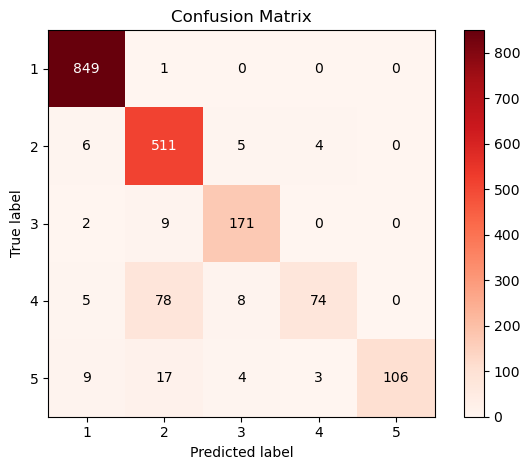

23/05/11 20:10:44 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks (after 1 retries)
java.io.IOException: Failed to connect to /10.15.177.178:61462
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:288)
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:218)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:126)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:154)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.lambda$initiateRetry$0(RetryingBlockTransferor.java:184)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:11

In [511]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Reds')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
thresh = confusion_matrix.max() / 2.
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()